In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta

from typing import List, Union

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve

import nbimporter
from Functions import getTEvents, get_dollar_bars, get_returns

## Auxilary functions

In [2]:
def get_daily_vol(close: pd.Series, span0: int = 20) -> pd.Series:
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1)) # indices of 1 day before
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]) # timestamps -> 1 day before
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1    # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

In [3]:
def apply_tripple_barrier(close: pd.Series, events: pd.DataFrame,
                                   pt_sl: List, molecule: np.ndarray) -> pd.DataFrame:
    '''
    Labeling observations using tripple-barrier method
    
        Parameters:
            close (pd.Series): close prices of bars
            events (pd.DataFrame): dataframe with columns:
                                   - t1: The timestamp of vertical barrier (if np.nan, there will not be
                                         a vertical barrier)
                                   - trgt: The unit width of the horizontal barriers
            pt_sl (list): list of two non-negative float values:
                          - pt_sl[0]: The factor that multiplies trgt to set the width of the upper barrier.
                                      If 0, there will not be an upper barrier.
                          - pt_sl[1]: The factor that multiplies trgt to set the width of the lower barrier.
                                      If 0, there will not be a lower barrier.
            molecule (np.ndarray):  subset of event indices that will be processed by a
                                    single thread (will be used later)
        
        Returns:
            out (pd.DataFrame): dataframe with columns [pt, sl, t1] corresponding to timestamps at which
                                each barrier was touched (if it happened)
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(data=[np.nan] * len(events.index), index=events.index)    # NaNs
    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(data=[np.nan] * len(events.index), index=events.index)    # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc: t1]                                       # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']     # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()        # earlisest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()        # earlisest profit taking
    return out

In [4]:
# including metalabeleing possibility
def get_events_tripple_barrier(
    close: pd.Series, tEvents: np.ndarray, pt_sl: float, trgt: pd.Series, minRet: float,
    numThreads: int = 1, t1: Union[pd.Series, bool] = False, side: pd.Series = None
) -> pd.DataFrame:
    '''
    Getting times of the first barrier touch
    
        Parameters:
            close (pd.Series): close prices of bars
            tEvents (np.ndarray): np.ndarray of timestamps that seed every barrier (they can be generated
                                  by CUSUM filter for example)
            pt_sl (float): non-negative float that sets the width of the two barriers (if 0 then no barrier)
            trgt (pd.Series): s series of targets expressed in terms of absolute returns
            minRet (float): minimum target return required for running a triple barrier search
            numThreads (int): number of threads to use concurrently
            t1 (pd.Series): series with the timestamps of the vertical barriers (pass False
                            to disable vertical barriers)
            side (pd.Series) (optional): metalabels containing sides of bets
        
        Returns:
            events (pd.DataFrame): dataframe with columns:
                                       - t1: timestamp of the first barrier touch
                                       - trgt: target that was used to generate the horizontal barriers
                                       - side (optional): side of bets
    '''
    trgt = trgt.loc[trgt.index.intersection(tEvents)]
    trgt = trgt[trgt > minRet]
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    if side is None:
        side_, pt_sl_ = pd.Series(np.ones(len(trgt.index)), index=trgt.index), [pt_sl[0], pt_sl[0]]
    else:
        side_, pt_sl_ = side.loc[trgt.index.intersection(side.index)], pt_sl[:2]
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])
    df0 = apply_tripple_barrier(close, events, pt_sl_, events.index)
#     df0 = mpPandasObj(func=apply_tripple_barrier, pdObj=('molecule', events.index),
#                       numThreads=numThreads, close=close, events=events, pt_sl=[pt_sl, pt_sl])
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events

Here we don't use the `mpPandasObj` multiprocessing function that appears in the book later in Chapter 20.

In [5]:
def add_vertical_barrier(close: pd.Series, tEvents: np.ndarray, numDays: int) -> pd.Series:
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]])    # adding NaNs to the end
    return t1

In [6]:
# including metalabeling possibility & modified to generate 0 labels
def get_bins(close: pd.Series, events: pd.DataFrame, t1: Union[pd.Series, bool] = False) -> pd.DataFrame:
    '''
    Generating labels with possibility of knowing the side (metalabeling)
    
        Parameters:
            close (pd.Series): close prices of bars
            events (pd.DataFrame): dataframe returned by 'get_events' with columns:
                                   - index: event starttime
                                   - t1: event endtime
                                   - trgt: event target
                                   - side (optional): position side
            t1 (pd.Series): series with the timestamps of the vertical barriers (pass False
                            to disable vertical barriers)
        
        Returns:
            out (pd.DataFrame): dataframe with columns:
                                       - ret: return realized at the time of the first touched barrier
                                       - bin: if metalabeling ('side' in events), then {0, 1} (take the bet or pass)
                                              if no metalabeling, then {-1, 1} (buy or sell)
    '''
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side']
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0
    else:
        if t1 is not None:
            vertical_first_touch_idx = events_[events_['t1'].isin(t1.values)].index
            out.loc[vertical_first_touch_idx, 'bin'] = 0
    return out

With metalabeling, using labels generated by `get_bins` function, ML algorithm is trained to make a purely binary decision - 0 or 1. When the predicted label is 1, we can use the probability of this secondary prediction to derive the size of the
bet, where the side (sign) of the position has been set by the primary (meta-) model.

In [7]:
def drop_labels(labels: pd.DataFrame, min_pct: float = 0.05) -> pd.DataFrame:
    while True:
        df0 = labels['bin'].value_counts(normalize=True)
        if df0.min() > min_pct or df0.shape[0] < 3:
            break
        print('dropped label', df0.argmin(), df0.min())
        labels = labels[labels['bin'] != df0.index[df0.argmin()]]
    return labels

## Exercises

Here I use the clean dataset generated in `Chapter2.ipynb`. All the necessary functions implemented in that file are imported here.

In [8]:
data = pd.read_csv('sp10-19.csv')
data.head()

,price,volume,datetime
0,1113.2,1,2010-01-03 17:00:00
1,1113.2,1,2010-01-03 17:00:00
2,1113.2,1,2010-01-03 17:00:00
3,1113.2,1,2010-01-03 17:00:00
4,1113.2,1,2010-01-03 17:00:00


### 1. Dollar Bars, CUSUM filter & Tripple-Barrier Method

In [9]:
# $50,000 per bar
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 50000)
dollar_bars_df = pd.DataFrame(data=dollar_bars[:, 1:], index=dollar_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
dollar_bars_df = dollar_bars_df[~dollar_bars_df.index.duplicated(keep='first')]
# fig = go.Figure(
#     data=[go.Candlestick(x=dollar_bars_df.index, open=dollar_bars_df['open'],
#                          high=dollar_bars_df['high'], low=dollar_bars_df['low'], close=dollar_bars_df['close'])]
# ).update_layout(xaxis_title="Time", yaxis_title="Price", title="Dollar Bars")
# fig.show()

Aplly a symmetric CUSUM filter to obtained dollar bars with threshold equal to mean daily returns std:

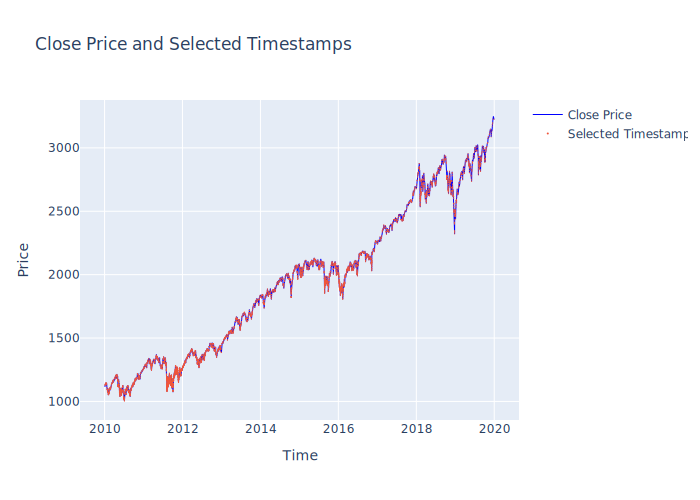

In [25]:
mean_std = get_daily_vol(dollar_bars_df['close']).mean()
dollar_ret = get_returns(dollar_bars)

tEvents = getTEvents(dollar_ret, h=mean_std)
chosen_bars_df = dollar_bars_df.loc[tEvents, :]

fig = go.Figure(
    go.Scatter(x=dollar_bars_df.index, y=dollar_bars_df['close'],
               line=dict(color="blue", width=1), name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price and Selected Timestamps")
fig.add_trace(go.Scatter(
    x=chosen_bars_df.index, y=chosen_bars_df['close'], mode='markers', marker=dict(size=1), name='Selected Timestamps'
    )
)
fig.show()

Add vertical barriers:

In [11]:
t1 = add_vertical_barrier(dollar_bars_df['close'], tEvents, numDays=1)
t1

2010-01-04 15:31:02.000   2010-01-05 15:34:19.000
2010-01-04 16:26:25.000   2010-01-05 17:49:08.000
2010-01-05 19:51:47.000   2010-01-06 21:36:06.000
2010-01-07 16:10:20.000   2010-01-10 17:02:07.000
2010-01-07 17:59:38.000   2010-01-10 17:02:07.000
                                    ...          
2019-12-12 21:09:53.757   2019-12-17 07:25:09.155
2019-12-13 06:58:48.329   2019-12-17 07:25:09.155
2019-12-17 07:25:09.155   2019-12-18 08:11:34.083
2019-12-17 07:48:29.219   2019-12-18 08:11:34.083
2019-12-20 08:11:47.600   2019-12-24 07:26:30.124
Length: 6463, dtype: datetime64[ns]

Now let's apply the tripple-barrier method with `pt_sl=[1, 1]` and generated `t1`. Here we have to choose the minimum target return to run the tripple-barrier method, let it be `minRet=0.007` (so that I get more data points). As a `trgt` for horizontal barriers I use daily volatility.

In [12]:
events = get_events_tripple_barrier(close=dollar_bars_df['close'], tEvents=tEvents, pt_sl=[1, 1],
                                    trgt=get_daily_vol(dollar_bars_df['close']), minRet=0.007,
                                    numThreads=1, t1=t1)
events

,t1,trgt
2010-01-21 15:41:16.000,2010-01-24 17:26:29.000,0.007767
2010-01-28 17:01:37.000,2010-01-31 17:00:05.000,0.009008
2010-01-28 21:22:56.000,2010-01-31 17:00:05.000,0.013672
2010-01-28 22:25:49.000,2010-01-31 17:00:05.000,0.013559
2010-01-29 00:24:20.000,2010-01-29 07:32:32.000,0.012875
...,...,...
2019-12-13 06:58:48.329,2019-12-17 07:25:09.155,0.008966
2019-12-17 07:25:09.155,2019-12-18 08:11:34.083,0.008693
2019-12-17 07:48:29.219,2019-12-18 08:11:34.083,0.008380
2019-12-20 08:11:47.600,2019-12-24 07:26:30.124,0.007784


Finally, let's get out labels:

In [58]:
labels = get_bins(close=dollar_bars_df['close'], events=events, t1=t1)
labels

,ret,bin
2010-01-21 15:41:16.000,-0.012078,0
2010-01-28 17:01:37.000,-0.009443,0
2010-01-28 21:22:56.000,-0.009259,0
2010-01-28 22:25:49.000,-0.005946,0
2010-01-29 00:24:20.000,0.01314,1
...,...,...
2019-12-12 21:09:53.757,0.004491,0
2019-12-13 06:58:48.329,0.008546,0
2019-12-17 07:25:09.155,0.000125,0
2019-12-17 07:48:29.219,0.00144,0


In [14]:
labels.describe()

,ret,bin
count,1865.0,1865
unique,1840.0,3
top,0.0,0
freq,4.0,1104


Note that here we used the possibility of zero labels so there are 3 labels we get - 1, -1 and 0. Therefore, we can apply `drop_labels` to drop the least popular label:

In [15]:
labels = drop_labels(labels, min_pct=0.05)
labels

,ret,bin
2010-01-21 15:41:16.000,-0.012078,0
2010-01-28 17:01:37.000,-0.009443,0
2010-01-28 21:22:56.000,-0.009259,0
2010-01-28 22:25:49.000,-0.005946,0
2010-01-29 00:24:20.000,0.01314,1
...,...,...
2019-12-12 21:09:53.757,0.004491,0
2019-12-13 06:58:48.329,0.008546,0
2019-12-17 07:25:09.155,0.000125,0
2019-12-17 07:48:29.219,0.00144,0


No label is dropped meaning there is no huge imbalance in the `labels` dataset.

### 2. Crossing Moving Average Strategy

In [59]:
pd.DataFrame({'a': [1,2,3]}).shift(-1)

,a
0,2.0
1,3.0
2,NaN


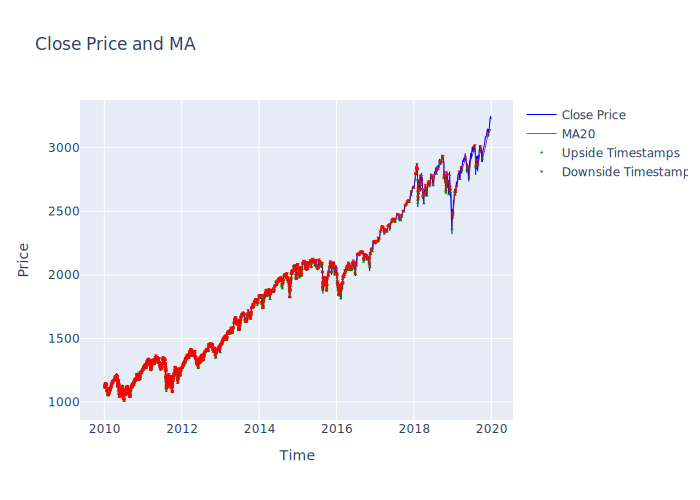

In [16]:
dollar_bars_df_ma = dollar_bars_df.copy(deep=True)
dollar_bars_df_ma['ma'] = dollar_bars_df_ma['close'].rolling(30, min_periods=1).mean()

def get_upside_bars_ma(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['close'] < df['ma']) & (df.shift(-1)['close'] > df.shift(-1)['ma'])]

def get_downside_bars_ma(df: pd.DataFrame) -> np.ndarray:
    return df[(df['close'] > df['ma']) & (df.shift(-1)['close'] < df.shift(-1)['ma'])]

up_timestamps, down_timestamps = get_upside_bars_ma(dollar_bars_df_ma), get_downside_bars_ma(dollar_bars_df_ma)

fig = go.Figure(
    go.Scatter(x=dollar_bars_df_ma.index, y=dollar_bars_df_ma['close'], line=dict(color="blue", width=1),
               name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price and MA")
fig.add_trace(go.Scatter(x=dollar_bars_df_ma.index, y=dollar_bars_df_ma['ma'], line=dict(color="purple", width=0.7),
                         name='MA20')
)
fig.add_trace(go.Scatter(
    x=up_timestamps.index, y=up_timestamps['close'], mode='markers',
    marker=dict(size=3, color='green', symbol=5), name='Upside Timestamps')
)
fig.add_trace(go.Scatter(
    x=down_timestamps.index, y=down_timestamps['close'], mode='markers',
    marker=dict(size=3, color='red', symbol=6), name='Downside Timestamps')
)
fig.show()

Now we have to derive metalabels using the events from the previous task (but now we have sides of bets):

In [17]:
side_index = up_timestamps.index.union(down_timestamps.index)
side_data = []
for idx in side_index:
    if idx in up_timestamps.index:
        side_data.append(1)
    else:
        side_data.append(-1)
side = pd.Series(data=side_data, index=side_index)

events_ma = get_events_tripple_barrier(close=dollar_bars_df['close'], tEvents=tEvents, pt_sl=[1, 2],
                                       trgt=get_daily_vol(dollar_bars_df['close']), minRet=0.007,
                                       numThreads=1, t1=t1, side=side)
events_ma = events_ma.dropna()
events_ma

,t1,trgt,side
2010-02-07 17:00:03.000,2010-02-08 17:23:01.000,0.007844,-1.0
2010-05-06 22:16:35.000,2010-05-09 17:00:39.000,0.008930,1.0
2010-05-09 17:33:54.000,2010-05-10 01:00:41.000,0.012741,1.0
2010-05-26 01:18:45.000,2010-05-26 16:28:26.000,0.013721,-1.0
2010-06-08 20:52:25.000,2010-06-10 15:36:20.000,0.010710,-1.0
...,...,...,...
2019-08-13 07:36:27.143,2019-08-13 20:15:53.882,0.016102,1.0
2019-08-14 04:15:14.597,2019-08-14 18:00:20.743,0.015476,-1.0
2019-08-15 22:00:34.126,2019-08-18 17:03:36.139,0.012305,1.0
2019-08-28 02:20:03.614,2019-08-29 02:23:12.318,0.007939,-1.0


Now we have to get the bins corresponding to chosen events:

In [18]:
bins_ma = get_bins(close=dollar_bars_df_ma['close'], events=events_ma, t1=t1)
bins_ma

,ret,bin
2010-02-07 17:00:03.000,0.005556,1
2010-05-06 22:16:35.000,0.004,1
2010-05-09 17:33:54.000,0.01297,1
2010-05-26 01:18:45.000,0.015088,1
2010-06-08 20:52:25.000,-0.021562,0
...,...,...
2019-08-13 07:36:27.143,0.021754,1
2019-08-14 04:15:14.597,0.024055,1
2019-08-15 22:00:34.126,0.013304,1
2019-08-28 02:20:03.614,-0.010341,0


Finally, we can train random forest to decide whether to trade or not. Here the only feature is the decision of the first-level algorithm - the side of the bet. In out case these are the sides given by the MA Crossing strategy.

RF accuracy: 0.75
RF precision: 0.75
RF recall: 1.0


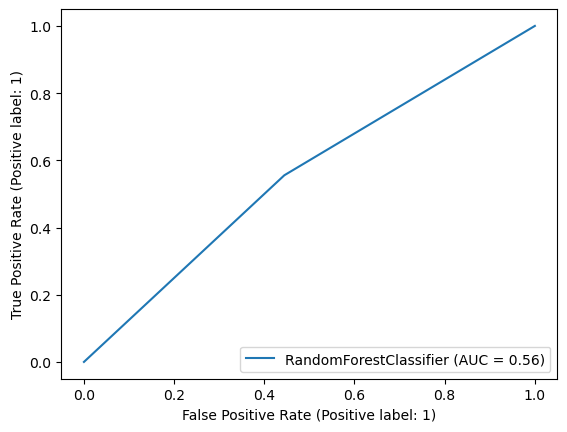

In [19]:
def print_results(rf: RandomForestClassifier, X_test: np.ndarray,
                  y_test: np.ndarray, y_pred: np.ndarray) -> None:
    print(f'RF accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'RF precision: {precision_score(y_test, y_pred)}')
    print(f'RF recall: {recall_score(y_test, y_pred)}')
    plot_roc_curve(rf, X_test, y_test)

X, y = events_ma['side'].values.reshape(-1, 1), bins_ma['bin'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print_results(rf, X_test, y_test, y_pred)

### 3. Bollinger Bands Mean-Reverting Strategy

Here we do practically the same thing but use Bollinger bands as the primary model.

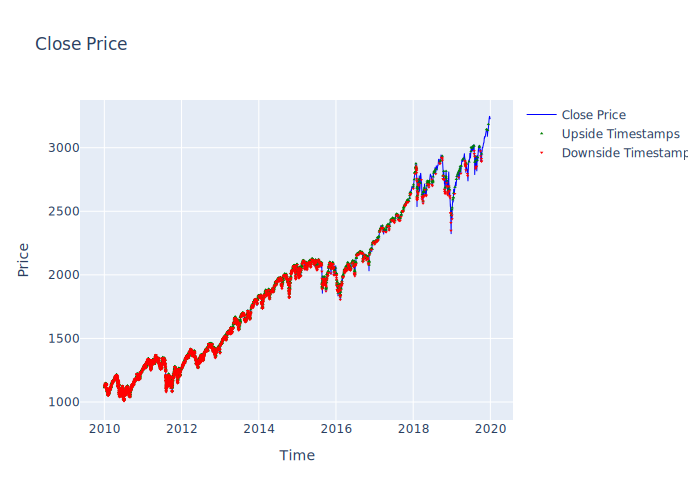

In [20]:
def get_bollinger_bands(dollar_bars: pd.DataFrame, alpha: float) -> np.ndarray:
    prices = dollar_bars['close']                                    # taking close prices
    ma = (prices.rolling(30, min_periods=1).mean())                  # 30 bars moving average
    sigma = prices.rolling(30, min_periods=1).std()
    sigma[0] = 0
    b_upper, b_lower = (ma + alpha * sigma), (ma - alpha * sigma)    # bollinger bounds    
    return np.array([ma, b_upper, b_lower])

ma, b_upper, b_lower = get_bollinger_bands(dollar_bars_df, 1)
dollar_bars_df_bb = dollar_bars_df.copy(deep=True)
dollar_bars_df_bb['ma'], dollar_bars_df_bb['b_upper'], dollar_bars_df_bb['b_lower'] = ma, b_upper, b_lower

def get_upside_bars_bb(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['open'] < df['b_upper']) & (df['close'] > df['b_upper'])]

def get_downside_bars_bb(df: pd.DataFrame) -> np.ndarray:
    return df[(df['open'] > df['b_lower']) & (df['close'] < df['b_lower'])]

up_timestamps, down_timestamps = get_upside_bars_bb(dollar_bars_df_bb), get_downside_bars_bb(dollar_bars_df_bb)

fig = go.Figure(
    go.Scatter(x=dollar_bars_df_bb.index, y=dollar_bars_df_bb['close'], line=dict(color="blue", width=1),
               name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price")
fig.add_trace(go.Scatter(
    x=up_timestamps.index, y=up_timestamps['close'], mode='markers',
    marker=dict(size=3, color='green', symbol=5), name='Upside Timestamps')
)
fig.add_trace(go.Scatter(
    x=down_timestamps.index, y=down_timestamps['close'], mode='markers',
    marker=dict(size=3, color='red', symbol=6), name='Downside Timestamps')
)
fig.show()

In [21]:
side_index = up_timestamps.index.union(down_timestamps.index)
side_data = []
for idx in side_index:
    if idx in up_timestamps.index:
        side_data.append(1)
    else:
        side_data.append(-1)
side = pd.Series(data=side_data, index=side_index)

events_bb = get_events_tripple_barrier(close=dollar_bars_df['close'], tEvents=tEvents, pt_sl=[0, 2],
                                       trgt=get_daily_vol(dollar_bars_df['close']), minRet=0.007,
                                       numThreads=1, t1=t1, side=side)
events_bb = events_bb.dropna()
events_bb

,t1,trgt,side
2010-01-28 22:25:49.000,2010-01-31 17:00:05.000,0.013559,-1.0
2010-02-07 17:19:56.000,2010-02-08 17:23:01.000,0.009584,-1.0
2010-05-06 15:31:04.000,2010-05-09 17:00:39.000,0.009708,-1.0
2010-05-14 00:53:31.000,2010-05-16 17:00:40.000,0.010092,-1.0
2010-05-20 19:41:22.000,2010-05-23 17:02:38.000,0.010745,-1.0
...,...,...,...
2019-09-30 02:51:33.929,2019-10-01 03:56:27.720,0.007712,-1.0
2019-10-02 01:13:16.891,2019-10-03 05:43:28.139,0.007863,-1.0
2019-10-08 06:00:10.006,2019-10-09 17:19:56.860,0.010705,-1.0
2019-10-10 15:34:10.236,2019-10-14 02:28:27.505,0.007734,1.0


In [22]:
bins_bb = get_bins(close=dollar_bars_df_bb['close'], events=events_bb, t1=t1)
bins_bb

,ret,bin
2010-01-28 22:25:49.000,0.005946,1
2010-02-07 17:19:56.000,0.002456,1
2010-05-06 15:31:04.000,-0.005967,0
2010-05-14 00:53:31.000,0.019972,1
2010-05-20 19:41:22.000,-0.018209,0
...,...,...
2019-09-30 02:51:33.929,-0.004843,0
2019-10-02 01:13:16.891,0.015273,1
2019-10-08 06:00:10.006,0.000618,1
2019-10-10 15:34:10.236,0.005081,1


Now we can train the secondary random forest model. Apart from the sides given by the primary model, I add volatility and autocorreation to the features.

RF accuracy: 0.5365853658536586
RF precision: 0.5757575757575758
RF recall: 0.4418604651162791


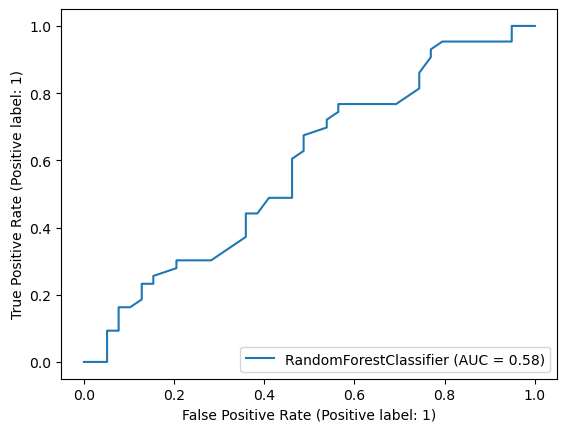

In [23]:
X = pd.DataFrame(
    {'vol': get_daily_vol(dollar_bars_df['close']),
     'autocorr': dollar_ret.rolling(20, min_periods=1).corr(dollar_ret.shift(1)).dropna(),
     'side': events_bb['side']}
).dropna()
X = X[~X.index.duplicated(keep='first')]
y = bins_bb['bin'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print_results(rf, X_test, y_test, y_pred)

We can compare results of this 2-level model to results that can be achieved by using only primary model (based on Bollinger bands):

In [24]:
# change classes from {-1, -1} to {0, 1}
y_pred_primary = ((pd.concat((events_bb, bins_bb), axis=1)['side'] + 1) / 2).astype(int)[-X_test.shape[0]:]

print(f'Primary model accuracy: {accuracy_score(y_test, y_pred_primary)}')
print(f'Primary model precision: {precision_score(y_test, y_pred_primary)}')
print(f'Primary model recall: {recall_score(y_test, y_pred_primary)}')

Primary model accuracy: 0.6097560975609756
Primary model precision: 0.6341463414634146
Primary model recall: 0.6046511627906976
